In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## For 10 Neurons

In [3]:
T = 200
dt = 0.01
time = np.arange(0, T, dt)
n_steps = len(time)

Cm = 1.0
gNa = 120.0
gK = 36.0
gL = 0.3
ENa = 50.0
EK = -77.0
EL = -54.4

n_neurons = 10

input_currents = []

I0 = np.zeros(n_steps)
I0[1000:3000] = 25.0
I0[8000:10000] = 30.0
I0[15000:17000] = 20.0
input_currents.append(I0)

I1 = np.zeros(n_steps)
for i in range(2000, 18000, 600):
    I1[i:i+300] = 18.0
input_currents.append(I1)

I2 = np.zeros(n_steps)
I2[3000:16000] = 12.0 + 6.0 * np.sin(0.02 * np.arange(13000))
input_currents.append(I2)

I3 = np.zeros(n_steps)
for i in range(1500, 19000, 1000):
    I3[i:i+200] = 22.0
input_currents.append(I3)

I4 = np.zeros(n_steps)
I4[5000:15000] = 15.0
input_currents.append(I4)

I5 = np.zeros(n_steps)
I5[2000:18000] = 10.0 + 8.0 * np.sin(0.015 * np.arange(16000))
input_currents.append(I5)

I6 = np.zeros(n_steps)
noise = np.random.normal(0, 3, n_steps)
I6[4000:17000] = 12.0 + noise[4000:17000]
I6 = np.convolve(I6, np.ones(50)/50, mode='same')
input_currents.append(I6)

I7 = np.zeros(n_steps)
for i in range(3000, 18000, 1500):
    I7[i:i+500] = 20.0
input_currents.append(I7)

I8 = np.zeros(n_steps)
I8[1000:4000] = 18.0
I8[6000:9000] = 22.0
I8[11000:14000] = 25.0
I8[16000:19000] = 20.0
input_currents.append(I8)

I9 = np.zeros(n_steps)
I9[2000:18000] = 8.0 + 5.0 * np.sin(0.03 * np.arange(16000)) + 3.0 * np.sin(0.07 * np.arange(16000))
input_currents.append(I9)

def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1.0 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)

In [4]:
class HHNeuron:
    def __init__(self, name="Neuron"):
        self.V = -65.0
        self.m = 0.05
        self.h = 0.6
        self.n = 0.32
        self.name = name
        self.voltage_history = []
        self.synaptic_input = 0.0
        self.spike_times = []
        
    def step(self, dt, external_current=0.0, time_point=0):
        V, m, h, n = self.V, self.m, self.h, self.n
        
        m += dt * (alpha_m(V) * (1-m) - beta_m(V) * m)
        h += dt * (alpha_h(V) * (1-h) - beta_h(V) * h)
        n += dt * (alpha_n(V) * (1-n) - beta_n(V) * n)
        
        gNa_t = gNa * m**3 * h
        gK_t = gK * n**4
        
        INa = gNa_t * (V - ENa)
        IK = gK_t * (V - EK)
        IL = gL * (V - EL)
        
        I_total = external_current + self.synaptic_input
        
        dV_dt = (I_total - INa - IK - IL) / Cm
        V += dt * dV_dt
        
        self.V, self.m, self.h, self.n = V, m, h, n
        self.voltage_history.append(V)
        
        self.synaptic_input *= np.exp(-dt / 3.0)
        
        if V > 0 and (len(self.spike_times) == 0 or time_point - self.spike_times[-1] > 2.0):
            self.spike_times.append(time_point)
            return True
        return False



Simulating neural network with 10 neurons...


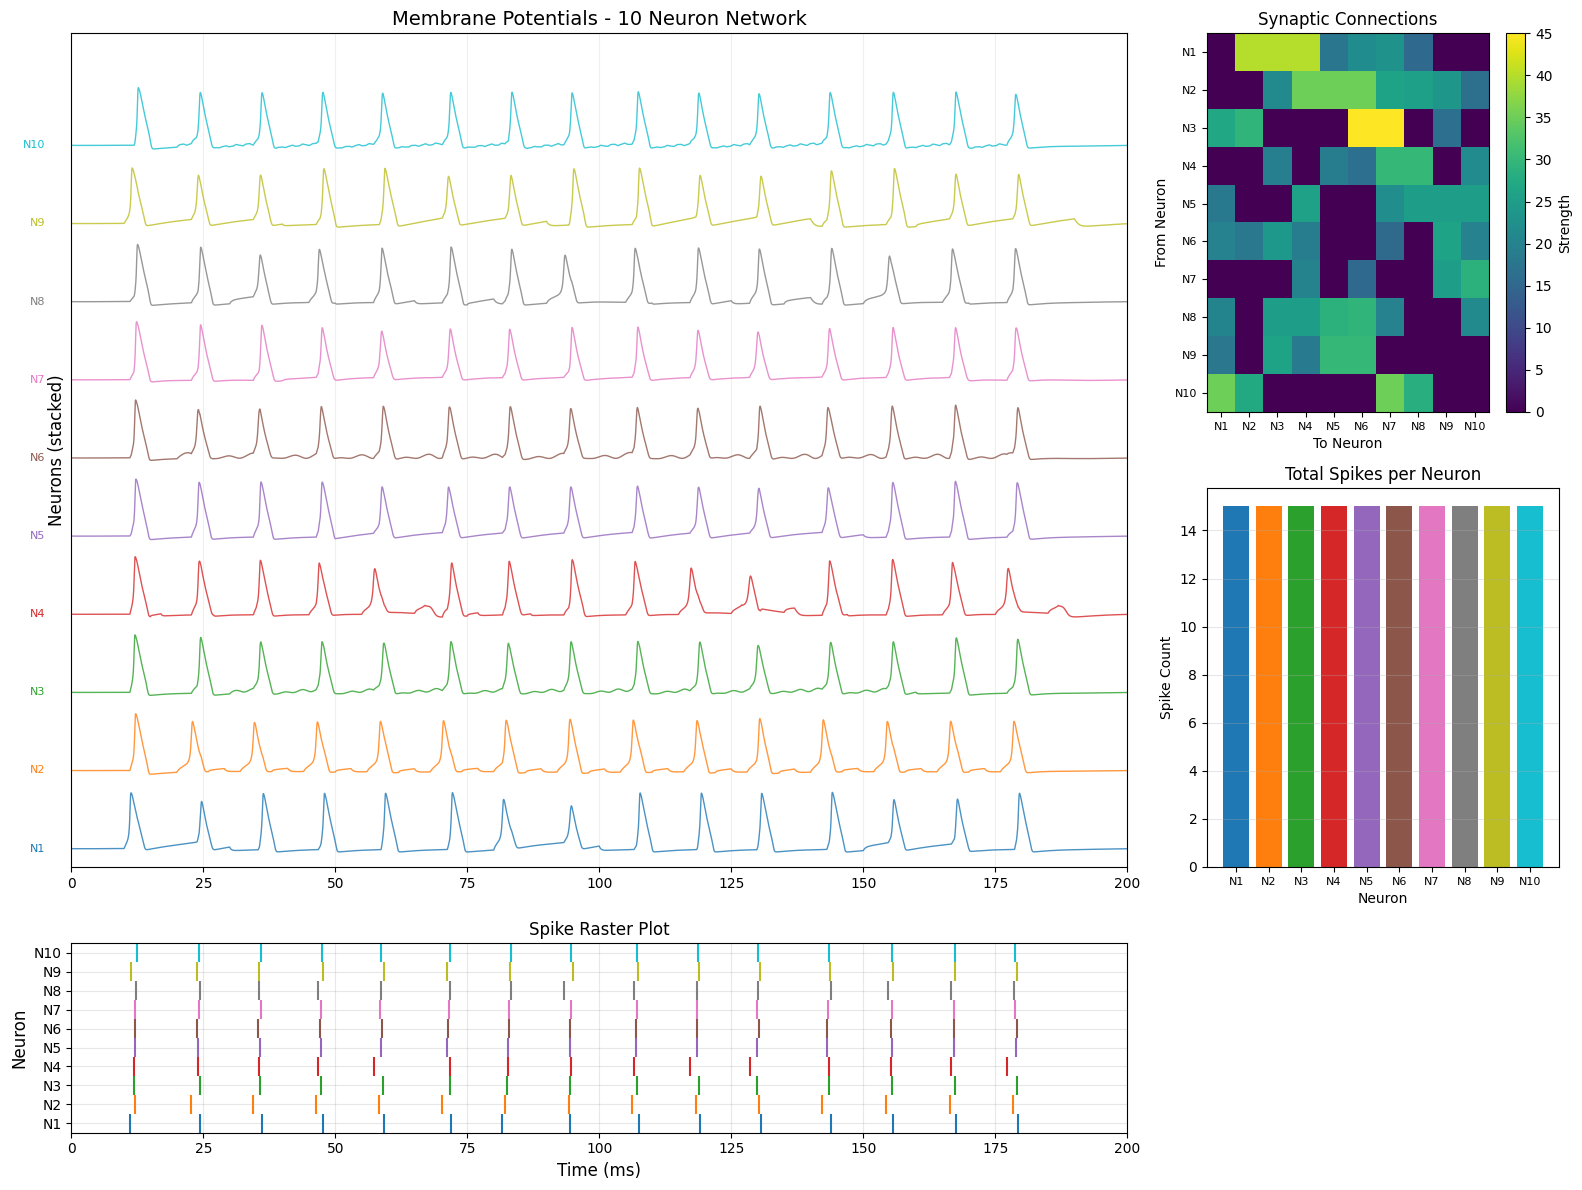


Network Statistics:
Total spikes: 150
Average spikes per neuron: 15.0

Individual neuron statistics:
N1: 15 spikes (avg rate: 83.2 Hz)
N2: 15 spikes (avg rate: 84.2 Hz)
N3: 15 spikes (avg rate: 83.7 Hz)
N4: 15 spikes (avg rate: 84.7 Hz)
N5: 15 spikes (avg rate: 83.9 Hz)
N6: 15 spikes (avg rate: 83.8 Hz)
N7: 15 spikes (avg rate: 84.1 Hz)
N8: 15 spikes (avg rate: 84.2 Hz)
N9: 15 spikes (avg rate: 83.4 Hz)
N10: 15 spikes (avg rate: 84.3 Hz)


In [5]:
neurons = [HHNeuron(f"N{i+1}") for i in range(n_neurons)]

connections = np.random.rand(n_neurons, n_neurons) * 30
np.fill_diagonal(connections, 0)

connections[0, [1, 2, 3]] = 40.0
connections[1, [3, 4, 5]] = 35.0
connections[2, [5, 6]] = 45.0
connections[3, [6, 7]] = 30.0
connections[4, [7, 8, 9]] = 25.0
connections[5, [0, 9]] = 20.0
connections[6, [0, 1]] = 15.0
connections[7, [2, 3]] = 25.0
connections[8, [4, 5]] = 30.0
connections[9, [0, 6]] = 35.0

connections = connections * (connections > 15)

print("Simulating neural network with 10 neurons...")

for i, t in enumerate(time):
    spikes = []
    for j, neuron in enumerate(neurons):
        spike = neuron.step(dt, input_currents[j][i], t)
        spikes.append(spike)
    
    for pre in range(len(neurons)):
        if spikes[pre]:
            for post in range(len(neurons)):
                if connections[pre][post] > 0:
                    neurons[post].synaptic_input += connections[pre][post]

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 1], width_ratios=[3, 1])

ax_voltage = fig.add_subplot(gs[0:2, 0])
ax_raster = fig.add_subplot(gs[2, 0])
ax_connectivity = fig.add_subplot(gs[0, 1])
ax_stats = fig.add_subplot(gs[1, 1])

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(n_neurons)]

for i, (neuron, color) in enumerate(zip(neurons, colors)):
    offset = i * 150
    voltage_shifted = np.array(neuron.voltage_history) + offset
    ax_voltage.plot(time, voltage_shifted, color=color, linewidth=1, alpha=0.8)
    ax_voltage.text(-5, offset - 65, neuron.name, fontsize=8, ha='right', va='center', color=color)

ax_voltage.set_ylabel('Neurons (stacked)', fontsize=12)
ax_voltage.set_title('Membrane Potentials - 10 Neuron Network', fontsize=14)
ax_voltage.set_xlim(0, T)
ax_voltage.set_ylim(-100, n_neurons * 150)
ax_voltage.grid(True, alpha=0.2)
ax_voltage.set_yticks([])

for i, (neuron, color) in enumerate(zip(neurons, colors)):
    if neuron.spike_times:
        ax_raster.eventplot(neuron.spike_times, lineoffsets=i, colors=color, linewidths=1.5)

ax_raster.set_xlabel('Time (ms)', fontsize=12)
ax_raster.set_ylabel('Neuron', fontsize=12)
ax_raster.set_xlim(0, T)
ax_raster.set_ylim(-0.5, n_neurons - 0.5)
ax_raster.set_yticks(range(n_neurons))
ax_raster.set_yticklabels([f'N{i+1}' for i in range(n_neurons)])
ax_raster.grid(True, alpha=0.3)
ax_raster.set_title('Spike Raster Plot', fontsize=12)

im = ax_connectivity.imshow(connections, cmap='viridis', aspect='auto')
ax_connectivity.set_xlabel('To Neuron', fontsize=10)
ax_connectivity.set_ylabel('From Neuron', fontsize=10)
ax_connectivity.set_title('Synaptic Connections', fontsize=12)
ax_connectivity.set_xticks(range(n_neurons))
ax_connectivity.set_yticks(range(n_neurons))
ax_connectivity.set_xticklabels([f'N{i+1}' for i in range(n_neurons)], fontsize=8)
ax_connectivity.set_yticklabels([f'N{i+1}' for i in range(n_neurons)], fontsize=8)
plt.colorbar(im, ax=ax_connectivity, label='Strength')

spike_counts = [len(neuron.spike_times) for neuron in neurons]
bars = ax_stats.bar(range(n_neurons), spike_counts, color=colors)
ax_stats.set_xlabel('Neuron', fontsize=10)
ax_stats.set_ylabel('Spike Count', fontsize=10)
ax_stats.set_title('Total Spikes per Neuron', fontsize=12)
ax_stats.set_xticks(range(n_neurons))
ax_stats.set_xticklabels([f'N{i+1}' for i in range(n_neurons)], fontsize=8)
ax_stats.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nNetwork Statistics:")
total_spikes = sum(spike_counts)
print(f"Total spikes: {total_spikes}")
print(f"Average spikes per neuron: {total_spikes/n_neurons:.1f}")
print(f"\nIndividual neuron statistics:")
for i, neuron in enumerate(neurons):
    print(f"{neuron.name}: {len(neuron.spike_times)} spikes", end="")
    if neuron.spike_times and len(neuron.spike_times) > 1:
        intervals = np.diff(neuron.spike_times)
        print(f" (avg rate: {1000/np.mean(intervals):.1f} Hz)")
    else:
        print()

## For 3 Neurons

Simulating neural network...


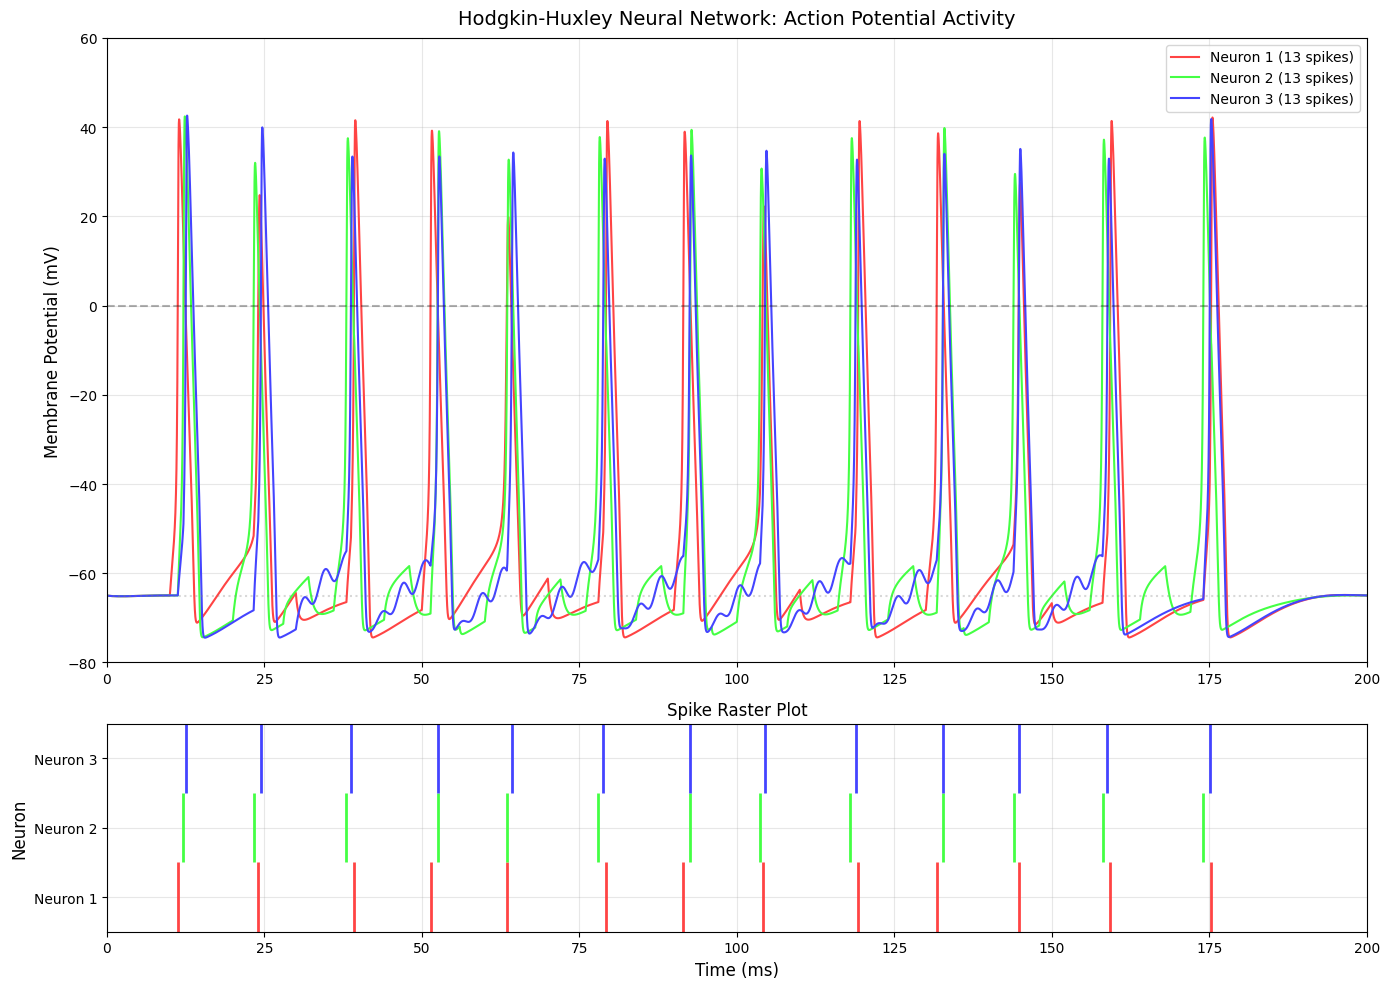


Spike Statistics:
Neuron 1: 13 spikes
  Average firing rate: 73.2 Hz
Neuron 2: 13 spikes
  Average firing rate: 74.1 Hz
Neuron 3: 13 spikes
  Average firing rate: 73.8 Hz


In [6]:
T = 200
dt = 0.01
time = np.arange(0, T, dt)
n_steps = len(time)

Cm = 1.0
gNa = 120.0
gK = 36.0
gL = 0.3
ENa = 50.0
EK = -77.0
EL = -54.4

input_currents = []

I0 = np.zeros(n_steps)
I0[1000:3000] = 20.0
I0[5000:7000] = 25.0
I0[9000:11000] = 22.0
I0[13000:15000] = 18.0
input_currents.append(I0)

I1 = np.zeros(n_steps)
for i in range(2000, 18000, 800):
    I1[i:i+400] = 15.0
input_currents.append(I1)

I2 = np.zeros(n_steps)
I2[3000:16000] = 10.0 + 5.0 * np.sin(0.02 * np.arange(13000))
input_currents.append(I2)

def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1.0 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)

class HHNeuron:
    def __init__(self, name="Neuron"):
        self.V = -65.0
        self.m = 0.05
        self.h = 0.6
        self.n = 0.32
        self.name = name
        self.voltage_history = []
        self.synaptic_input = 0.0
        self.spike_times = []
        
    def step(self, dt, external_current=0.0, time_point=0):
        V, m, h, n = self.V, self.m, self.h, self.n
        
        m += dt * (alpha_m(V) * (1-m) - beta_m(V) * m)
        h += dt * (alpha_h(V) * (1-h) - beta_h(V) * h)
        n += dt * (alpha_n(V) * (1-n) - beta_n(V) * n)
        
        gNa_t = gNa * m**3 * h
        gK_t = gK * n**4
        
        INa = gNa_t * (V - ENa)
        IK = gK_t * (V - EK)
        IL = gL * (V - EL)
        
        I_total = external_current + self.synaptic_input
        
        dV_dt = (I_total - INa - IK - IL) / Cm
        V += dt * dV_dt
        
        self.V, self.m, self.h, self.n = V, m, h, n
        self.voltage_history.append(V)
        
        self.synaptic_input *= np.exp(-dt / 3.0)
        
        if V > 0 and (len(self.spike_times) == 0 or time_point - self.spike_times[-1] > 2.0):
            self.spike_times.append(time_point)
            return True
        return False

neurons = [
    HHNeuron("Neuron 1"),
    HHNeuron("Neuron 2"), 
    HHNeuron("Neuron 3")
]

connections = np.array([
    [0,    40.0,  20.0],
    [25.0, 0,     35.0],
    [30.0, 15.0,  0   ]
])

print("Simulating neural network...")

for i, t in enumerate(time):
    spikes = []
    for j, neuron in enumerate(neurons):
        spike = neuron.step(dt, input_currents[j][i], t)
        spikes.append(spike)
    
    for pre in range(len(neurons)):
        if spikes[pre]:
            for post in range(len(neurons)):
                if connections[pre][post] > 0:
                    neurons[post].synaptic_input += connections[pre][post]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

colors = ['#FF4444', '#44FF44', '#4444FF']

for i, (neuron, color) in enumerate(zip(neurons, colors)):
    ax1.plot(time, neuron.voltage_history, 
             color=color, linewidth=1.5, label=f'{neuron.name} ({len(neuron.spike_times)} spikes)')

ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.axhline(y=-65, color='gray', linestyle=':', alpha=0.3)

ax1.set_ylabel('Membrane Potential (mV)', fontsize=12)
ax1.set_title('Hodgkin-Huxley Neural Network: Action Potential Activity', fontsize=14, pad=10)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, T)
ax1.set_ylim(-80, 60)

for i, (neuron, color) in enumerate(zip(neurons, colors)):
    spike_times = neuron.spike_times
    if spike_times:
        ax2.eventplot(spike_times, lineoffsets=i, colors=color, linewidths=2)

ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Neuron', fontsize=12)
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Neuron 1', 'Neuron 2', 'Neuron 3'])
ax2.set_xlim(0, T)
ax2.set_ylim(-0.5, 2.5)
ax2.grid(True, alpha=0.3)
ax2.set_title('Spike Raster Plot', fontsize=12)

plt.tight_layout()
plt.show()

print("\nSpike Statistics:")
for i, neuron in enumerate(neurons):
    print(f"{neuron.name}: {len(neuron.spike_times)} spikes")
    if neuron.spike_times:
        intervals = np.diff(neuron.spike_times)
        if len(intervals) > 0:
            print(f"  Average firing rate: {1000/np.mean(intervals):.1f} Hz")